# Web Traffic
### Jun 2021
* Instructor: John Navarro
* Author(s): Joshua Dai, Ellen Liu, Linqi Yang, Mengyang Yu

## Exploratory Data Analysis
* [data source](https://www.kaggle.com/c/web-traffic-time-series-forecasting)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('train_2.csv', index_col=0)
print(f'{train.shape[0]} time series (rows): daily views of each web page')
print(f'{train.shape[1]} days (columns): from {train.columns.min()} to {train.columns.max()}')
train.head(1)

145063 time series (rows): daily views of each web page
803 days (columns): from 2015-07-01 to 2017-09-10


,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
Page,,,,,,,,,,,,,,,,,,,,,
2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0


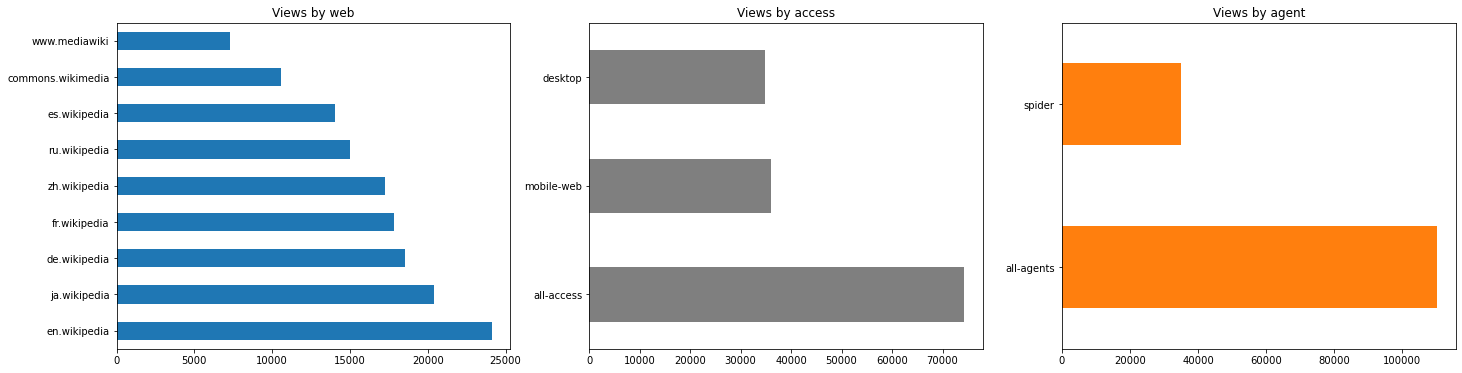

In [2]:
page_details = train.index.str.extract(r'(?P<topic>.*)\_(?P<web>.*).org\_(?P<access>.*)\_(?P<agent>.*)')
plt.figure(figsize=(24,6))
j = 1
c = ['tab:blue', 'tab:grey', 'tab:orange']
for i in page_details.columns[1:]: 
    plt.subplot(1,3,j)
    page_details[i].value_counts().plot(kind='barh', color=c[j-1])
    plt.title('Views by '+i)
    j+=1

* en.wikipedia: more views (US-based site), large spikes in Aug 2016 (olympics) & Nov 2016 (election)
* es.wikipedia: weekly seasonality, 6-month dip

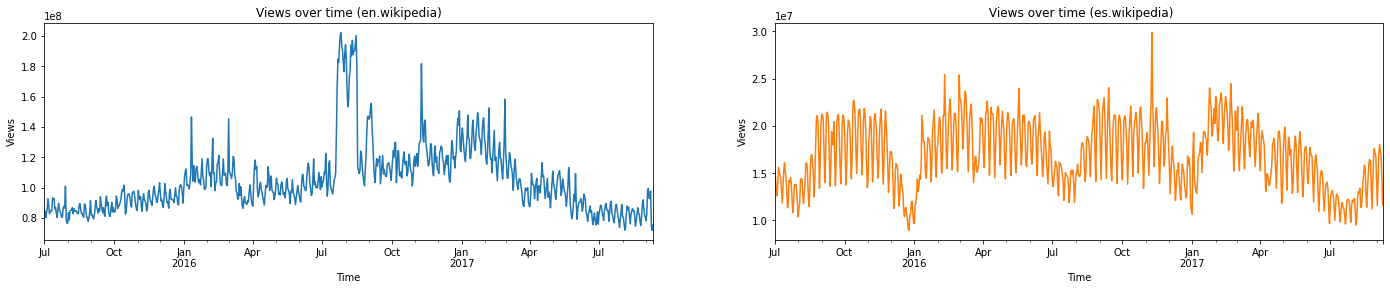

In [3]:
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

en = train.iloc[page_details[page_details['web'] == 'en.wikipedia'].index, :].sum()
en.index = pd.to_datetime(en.index)
en_dif = (en - en.shift(1)).iloc[1:,]

es = train.iloc[page_details[page_details['web'] == 'es.wikipedia'].index, :].sum()
es.index = pd.to_datetime(es.index)
es_dif = (es - es.shift(1)).iloc[1:,]

plt.figure(figsize=(24,4))
plt.subplot(121)
en.plot(title='Views over time (en.wikipedia)', xlabel='Time', ylabel='Views')
plt.subplot(122)
es.plot(title=' Views over time (es.wikipedia)', xlabel='Time', ylabel='Views', color='#ff7f0e');

* ACF: large spikes every 7 days due to weekly seasonality
* PACF: the first week has the largest spike

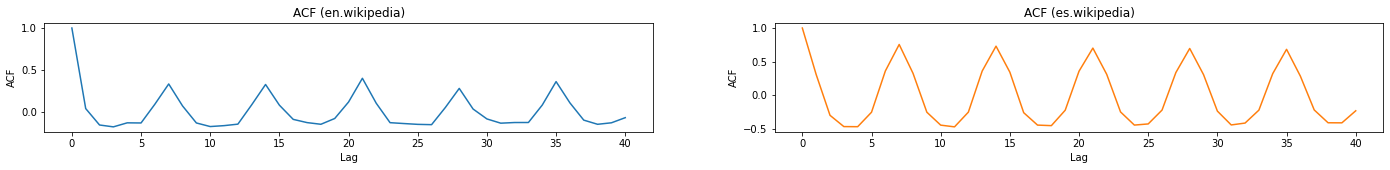

In [4]:
plt.figure(figsize=(24,2))
plt.subplot(121)
pd.Series(acf(en_dif)).plot(title='ACF (en.wikipedia)', xlabel='Lag', ylabel='ACF')
plt.subplot(122)
pd.Series(acf(es_dif)).plot(title='ACF (es.wikipedia)', xlabel='Lag', ylabel='ACF', color='#ff7f0e');

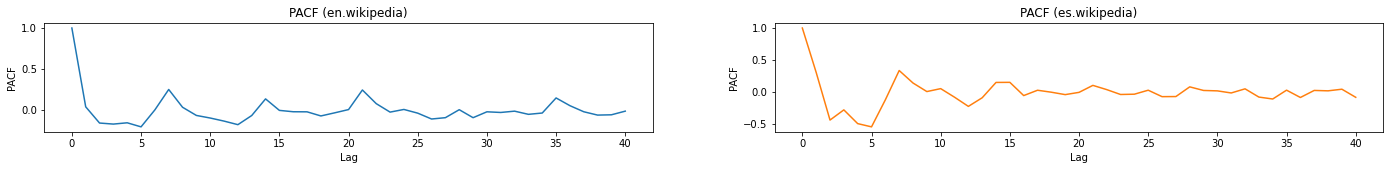

In [5]:
plt.figure(figsize=(24,2))
plt.subplot(121)
pd.Series(pacf(en_dif)).plot(title='PACF (en.wikipedia)', xlabel='Lag', ylabel='PACF')
plt.subplot(122)
pd.Series(pacf(es_dif)).plot(title='PACF (es.wikipedia)', xlabel='Lag', ylabel='PACF', color='#ff7f0e');

* es.wikipedia (all-agents vs spider): spider is approximately constant
* es.wikipedia (all-access vs desktop vs mobile-web): three groups have similar trends

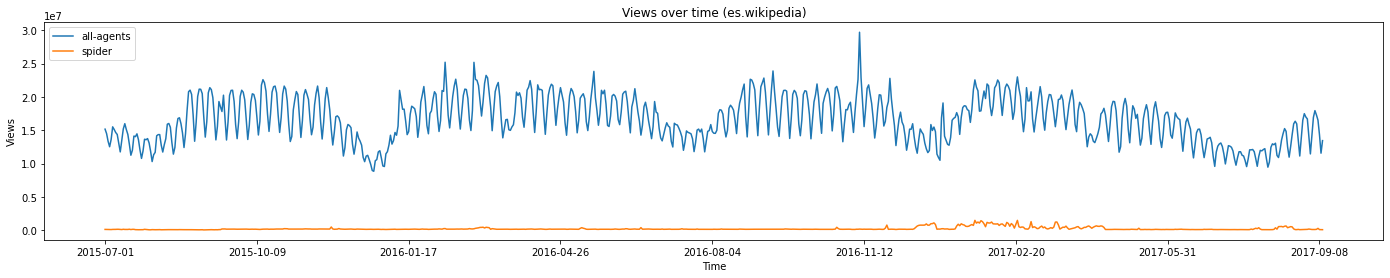

In [6]:
for i in np.unique(page_details['agent']): train.iloc[page_details[(page_details['agent'] == i) & (page_details['web'] == 'es.wikipedia')].index, :].sum().plot(label=i, figsize=(24,4))
plt.legend(loc='upper left')
plt.title('Views over time (es.wikipedia)')
plt.ylabel('Views')
plt.xlabel('Time');

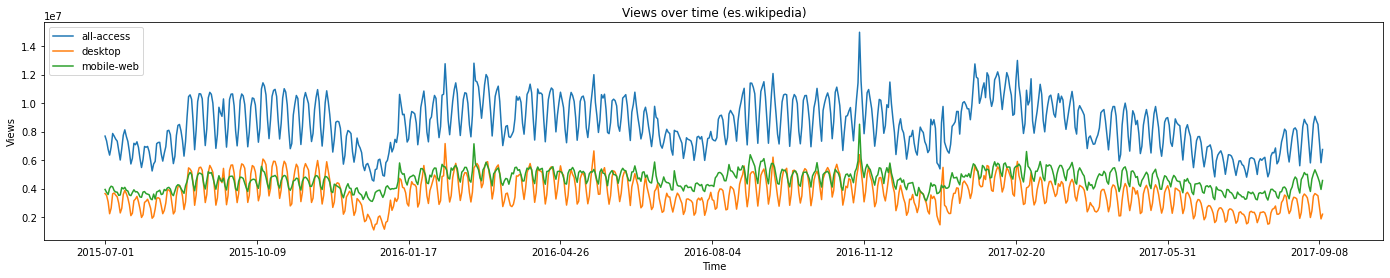

In [7]:
for i in np.unique(page_details['access']): train.iloc[page_details[(page_details['access'] == i) & (page_details['web'] == 'es.wikipedia')].index, :].sum().plot(label=i, figsize=(24,4))
plt.legend(loc='upper left')
plt.title('Views over time (es.wikipedia)')
plt.ylabel('Views')
plt.xlabel('Time');

## Feature Engineering
* missing values

9.3% web pages (329 out of 3537) have one or more missing value


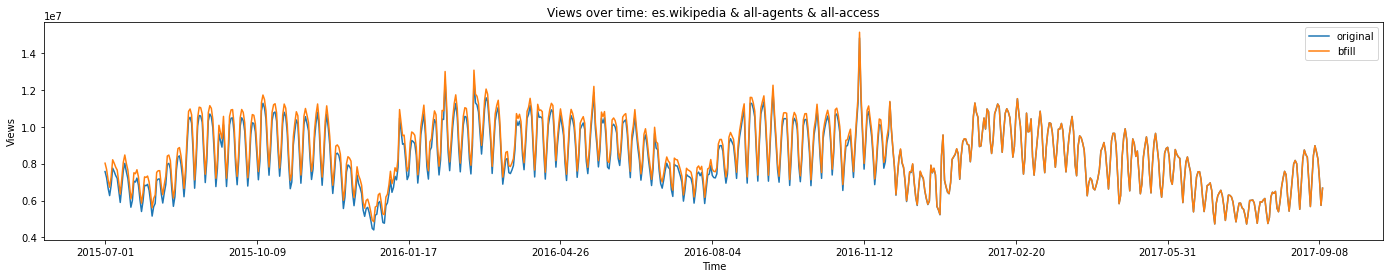

In [8]:
df = (page_details['access'] == 'all-access') & (page_details['agent'] == 'all-agents') & (page_details['web'] == 'es.wikipedia')
df = train.iloc[df[df].index,:]

na_num = sum(df.isna().sum(axis=1) != 0)
num = df.shape[0]
print(f'{round(na_num/num*100, 1)}% web pages ({na_num} out of {num}) have one or more missing value')

original = df.sum()
bfill = df.T.fillna(method='bfill').T.sum()
original.plot(figsize=(24,4), title='Views over time: es.wikipedia & all-agents & all-access', ylabel='Views', xlabel='Time', label='original')
bfill.plot(label='bfill')
plt.legend();

In [9]:
df = bfill.to_frame('Views').reset_index()
df.columns = ['ds', 'y']
df['ds'] = pd.to_datetime(df['ds'])
df.head()

,ds,y
0,2015-07-01,8022174.0
1,2015-07-02,7687790.0
2,2015-07-03,7121842.0
3,2015-07-04,6720181.0
4,2015-07-05,7275102.0


## ARIMA

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SMAPE: 8.10
MAPE: 0.08
MAE: 544328.77


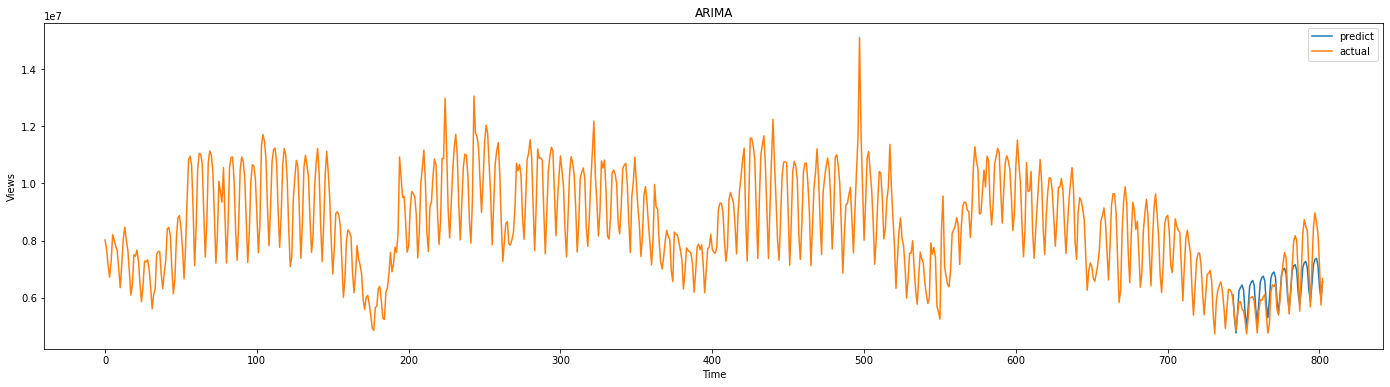

In [10]:
y_train = df[:-60]['y']
y_test = df[-60:]['y']

from sktime.forecasting.arima import ARIMA
arima_model = ARIMA(order=(7,0,7))
arima_model.fit(y_train)
predict = arima_model.predict(fh=list(range(1, 1+len(y_test))))
actual = y_test
residual = predict - actual

def smape(a, f): return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)
print('SMAPE: %.2f' %smape(actual, predict))
print('MAPE: %.2f' %np.mean(np.abs(residual)/np.abs(actual)))
print('MAE: %.2f' %np.mean(np.abs(residual)))

plt.figure(figsize=(24,6))
plt.plot(predict, label='predict')
plt.plot(df['y'], label='actual')
plt.legend()
plt.ylabel('Views')
plt.xlabel('Time')
plt.title('ARIMA');

## FBprophet

SMAPE: 6.71
MAPE: 0.06
MAE: 355183.71


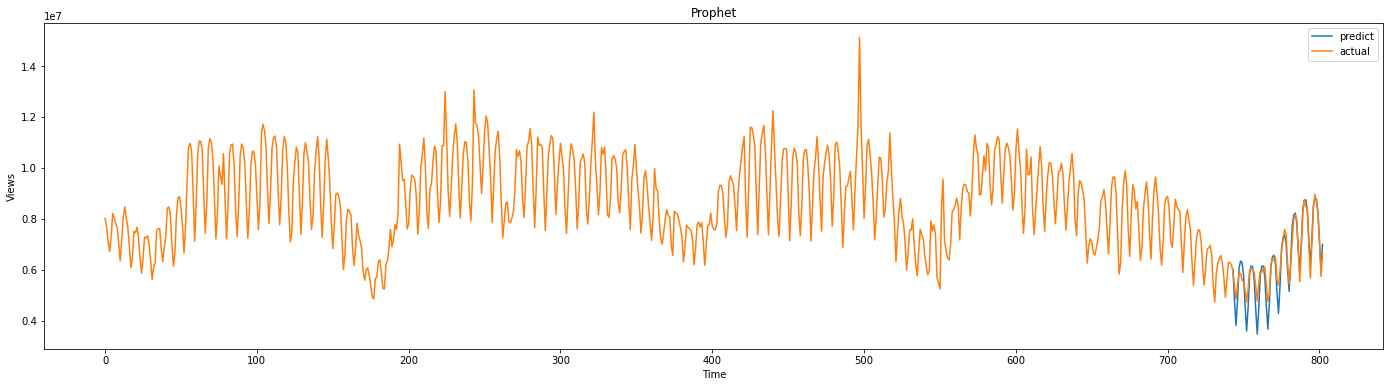

In [11]:
from fbprophet import Prophet
train_df = df[:-60]
m = Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=10, daily_seasonality=False)
m.fit(train_df)

forecast = m.predict(m.make_future_dataframe(periods=60))
predict = forecast.tail(n=60)["yhat"]
actual = df.tail(n=60)["y"]
residual = predict - actual

def smape(a, f): return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)
print('SMAPE: %.2f' %smape(actual, predict))
print('MAPE: %.2f' %np.mean(np.abs(residual)/np.abs(actual)))
print('MAE: %.2f' %np.mean(np.abs(residual)))

plt.figure(figsize=(24,6))
plt.plot(predict, label='predict')
plt.plot(df['y'], label='actual')
plt.legend()
plt.ylabel('Views')
plt.xlabel('Time')
plt.title('Prophet');

## RNN

In [12]:
df_cp = df.copy()
df_cp.columns = ['ds', 'X']
df_cp['y'] = df_cp['X'].shift(-5)
df_cp.dropna(inplace=True)
X, y = df_cp['X'], df_cp['y']
X_train, y_train, X_test, y_test = X[:-60], y[:-60], X[-60:], y[-60:]

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
y_train = mms.fit_transform(np.reshape(y_train.values, (-1,1)))
X_train = mms.fit_transform(np.reshape(X_train.values, (-1,1)))
X_train = np.reshape(X_train, (738,1,1))

from keras.models import Sequential
from keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(8, activation='relu', input_shape=(None, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=10, epochs=50)

# import keras
# from sklearn.model_selection import RandomizedSearchCV
# def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-2):
#     model = keras.models.Sequential()
#     model.add(LSTM(8, activation='relu', input_shape=(None, 1)))
#     for layer in range(n_hidden): model.add(keras.layers.Dense(n_neurons, activation="relu"))
#     model.add(keras.layers.Dense(1))
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model
# keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)
# param_distribs = {"n_hidden": [1, 2, 3],"n_neurons": np.arange(1, 100).tolist(),}
# rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
# rnd_search_cv.fit(X_train, y_train, epochs=50, callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50
74/74 [==============================] - 1s 1ms/step - loss: 0.1278
Epoch 2/50
74/74 [==============================] - 0s 831us/step - loss: 0.0644
Epoch 3/50
74/74 [==============================] - 0s 817us/step - loss: 0.0297
Epoch 4/50
74/74 [==============================] - 0s 922us/step - loss: 0.0204
Epoch 5/50
74/74 [==============================] - 0s 943us/step - loss: 0.0185
Epoch 6/50
74/74 [==============================] - 0s 956us/step - loss: 0.0200
Epoch 7/50
74/74 [==============================] - 0s 784us/step - loss: 0.0198
Epoch 8/50
74/74 [==============================] - 0s 685us/step - loss: 0.0205
Epoch 9/50
74/74 [==============================] - 0s 714us/step - loss: 0.0198
Epoch 10/50
74/74 [==============================] - 0s 701us/step - loss: 0.0208
Epoch 11/50
74/74 [==============================] - 0s 713us/step - loss: 0.0210
Epoch 12/50
74/74 [==============================] - 0s 701us/step - loss: 0.0194
Epoch 13/50
74/74 [========

SMAPE: 22.02
MAPE: 0.26
MAE: 1492184.67


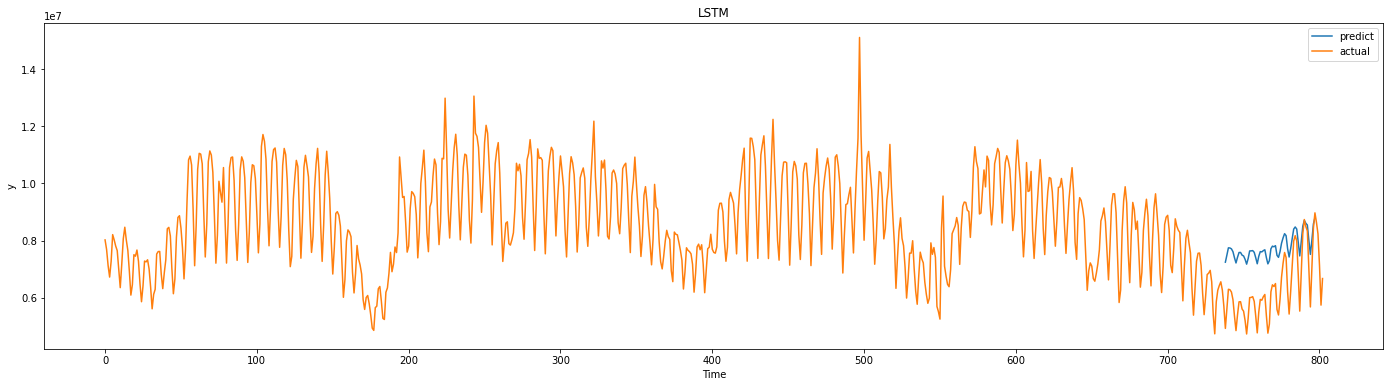

In [13]:
predict = mms.inverse_transform(model.predict(np.reshape(mms.transform(np.reshape(X_test.values,(-1,1))), (60, 1, 1))))
predict = pd.Series(np.reshape(predict, (1, -1))[0], index=y_test.index)
actual = y_test
residual = predict - actual

def smape(a, f): return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)
print('SMAPE: %.2f' %smape(actual, predict))
print('MAPE: %.2f' %np.mean(np.abs(residual)/np.abs(actual)))
print('MAE: %.2f' %np.mean(np.abs(residual)))

plt.figure(figsize=(24,6))
plt.plot(predict, label='predict')
plt.plot(df['y'], label='actual')
plt.legend()
plt.ylabel('y')
plt.xlabel('Time')
plt.title('LSTM');

## Extra Trees

In [14]:
df['Month'] = df['ds'].dt.month
df['Day'] = df['ds'].dt.day
df['Weekday'] = df['ds'].dt.dayofweek
df['Dif'] = df['y'] - df['y'].shift(1)
for i in range(1, 8): df['Dif Lag ' + str(i)] = df['Dif'].shift(i)
df.dropna(inplace=True)
df.head()

,ds,y,Month,Day,Weekday,Dif,Dif Lag 1,Dif Lag 2,Dif Lag 3,Dif Lag 4,Dif Lag 5,Dif Lag 6,Dif Lag 7
8,2015-07-09,7648772.0,7,9,3,-157965.0,-216611.0,-184575.0,932821.0,554921.0,-401661.0,-565948.0,-334384.0
9,2015-07-10,7001292.0,7,10,4,-647480.0,-157965.0,-216611.0,-184575.0,932821.0,554921.0,-401661.0,-565948.0
10,2015-07-11,6349850.0,7,11,5,-651442.0,-647480.0,-157965.0,-216611.0,-184575.0,932821.0,554921.0,-401661.0
11,2015-07-12,7175997.0,7,12,6,826147.0,-651442.0,-647480.0,-157965.0,-216611.0,-184575.0,932821.0,554921.0
12,2015-07-13,8065523.0,7,13,0,889526.0,826147.0,-651442.0,-647480.0,-157965.0,-216611.0,-184575.0,932821.0


SMAPE: 5.02
MAPE: 0.05
MAE: 322307.12


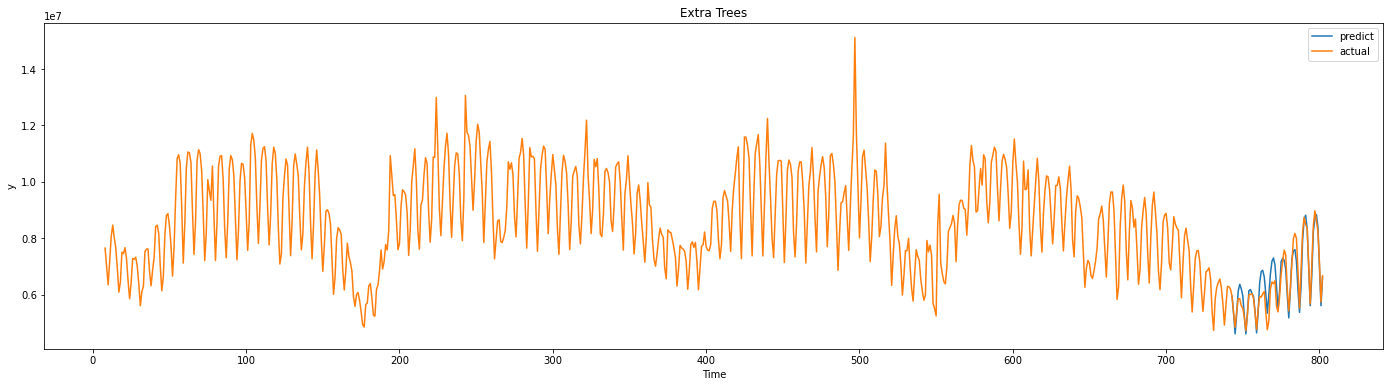

In [15]:
X = df[['Month'] + ['Day'] + ['Weekday'] + ['Dif Lag %d' % i for i in range(1, 8)]]
y = df['Dif']
X_train, y_train, X_test, y_test = X[:-60], y[:-60], X[-60:], y[-60:]

from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor(random_state=40)
model.fit(X_train, y_train)

actual = df.iloc[-60:]['y']
predict = pd.Series(df.iloc[-61]['y'] + model.predict(X_test).cumsum(), index=actual.index)
residual = predict - actual

def smape(a, f): return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)
print('SMAPE: %.2f' %smape(actual, predict))
print('MAPE: %.2f' %np.mean(np.abs(residual)/np.abs(actual)))
print('MAE: %.2f' %np.mean(np.abs(residual)))

plt.figure(figsize=(24,6))
plt.plot(predict, label='predict')
plt.plot(df['y'], label='actual')
plt.legend()
plt.ylabel('y')
plt.xlabel('Time')
plt.title('Extra Trees');